# Flux Plotting

In [3]:
# # Importing Packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import shutil
import imageio
import os
import natsort
from natsort import natsorted
from datetime import datetime, date, time
import scipy.io
from scipy.io import loadmat
from decimal import Decimal

####################################################################################################

reactor = input("Reactor? ")
efficiencies = natsorted([1, 0.8, 0.6, 0.4, 0.2, 0.15, 0.10, 0.05, 0.0])
eff = natsorted(list(((np.array(efficiencies) * 100).astype(int)).astype(str)))
print(natsorted(efficiencies))
print(natsorted(eff))

#####################################################################################################

beta_directory = "./Apollo/" + reactor

print("Searching directory for .out files...")
names = []
for root, dirs, files in os.walk(beta_directory):
    for file in files:
        if file.endswith(".out"):
            #print(os.path.join(root, file))
            names.append(os.path.join(root, file))

names = natsorted(names)
names
# ##############################################################################################
# ##############################################################################################
# ############################# PLOTTING FLUX COMPARISON #######################################
# ##############################################################################################
# ##############################################################################################

Reactor? MSBR
[0.0, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
['0', '5', '10', '15', '20', '40', '60', '80', '100']
Searching directory for .out files...


['./Apollo/MSBR\\MSBR_beta_0\\MSBR_burnup.out',
 './Apollo/MSBR\\MSBR_beta_5\\MSBR_beta_5.out',
 './Apollo/MSBR\\MSBR_beta_10\\MSBR_beta_10.out',
 './Apollo/MSBR\\MSBR_beta_15\\MSBR_beta_15.out',
 './Apollo/MSBR\\MSBR_beta_20\\MSBR_beta_20.out',
 './Apollo/MSBR\\MSBR_beta_40\\MSBR_beta_40.out',
 './Apollo/MSBR\\MSBR_beta_60\\MSBR_beta_60.out',
 './Apollo/MSBR\\MSBR_beta_80\\MSBR_beta_80.out',
 './Apollo/MSBR\\MSBR_beta_100\\MSBR_beta_100.out']

./Apollo/MSBR\MSBR_beta_0\MSBR_burnup.out
There are 11 transport calculation results.
Processing Comparison
The max mean flux is 121.57/cm^2*s
The max flux is 0.02504/cm^2*s
Plotting Comparison...


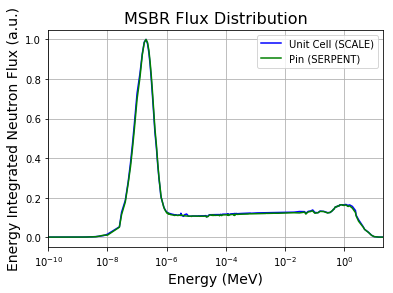

In [10]:
x = 0
#for i in range(0, len(eff)):
for i in range(0, 1):
    print(names[x])
    
    # Checking if folder already exists, if so remove it.
    text_path = ("./" + reactor + "/Flux_Plots/off_eff_" + eff[x] + "/") 
    if os.path.exists(text_path):
        shutil.rmtree(text_path)
    os.makedirs(text_path)
    
    # How many transport calculations are avaliable
    ocurrences = open(names[x], 'r').read().count(" Equivalent core height is infinite.")
    print("There are {} transport calculation results.".format(ocurrences))
    
    # Removing previous extraction of flux values
    text_path = ("./" + reactor + "/Flux_Plots/off_eff_" + eff[x] + "/result_" + reactor + ".txt")
    if os.path.exists(text_path):
        os.remove(text_path)
    
    # Adding all iterations to a single .txt file for future processing
    outfile = open(text_path, "a")
    with open(names[x], 'r') as f:
        textfile_temp = f.read()
        for i in range(1, (ocurrences + 1)):
            outfile.write(textfile_temp.split(
                '   No    Energy(eV)   Flux       Flux      Adj.Flux   Adj.Flux  \n')[i].split(
                " NOTE: Flux values above are per unit-lethargy.\n")[0])
    f.close()
    outfile.close()
    
    
    # ### SCALE Output into Dataframe; reading all iterations into dataframe
    headers = ['Group No', 'Upper Energy (eV)', 'Critical Flux', 'Inf. Med. Flux.', 
               'Critical Adj. Flux', 'Inf. Med. Adj. Flux']
    df = pd.read_csv(text_path, header=None, delimiter=r"\s+", names=headers)
    
    # Preparing folder to store each iteration graph to make .gif file
    flux_gif = "./" + reactor + "/Flux_Plots/off_eff_" + eff[x] + "/FluxGif"
    if os.path.exists(flux_gif):
        shutil.rmtree(flux_gif)
    os.makedirs(flux_gif)

    # To make gif look nice we make all images have the same scale
    if reactor == "MSRE":
        limity = (0, 0.050)
    elif reactor == "MSDR":
        limity = (0, 0.010)
    elif reactor == "MSBR":
        limity = (0, 0.035)
        
    # Plotting all iterations (neutron flux) 
    for i in range(0, ocurrences):
        ax = df.iloc[252*i:(252*(i+1)), [1,2]].plot('Upper Energy (eV)', 'Critical Flux', legend=None, ylim=limity)
        plt.grid()
        ax.set_ylabel("Neutron Flux per Unit Lethargy")
        ax.set_xlabel("Energy (eV)")
        ax.set_xscale('log')
        plt.savefig((flux_gif + "/step" + str(i) + ".png"), format='png', dpi=500)
        plt.close()

    # Setting path to save .gif file
    gif_path = "./" + reactor + "/Flux_Plots/off_eff_" + eff[x]
    images = [] #empty list where images will be stored for animation
    
    # Joining all images together to create gif
    for file_name in natsorted(os.listdir(flux_gif)):
        if file_name.endswith('.png'):
            file_path = os.path.join(flux_gif, file_name)
            images.append(imageio.imread(file_path))

    #Saving the images as an animation        
    imageio.mimsave((gif_path + '/Flux_Time.gif'), images, fps=10)
    
    # Plotting Comparison with Serpent (if detector file avaliable)
    if x == 0:
        text_path = ("./" + reactor + "/detectors.mat")
        if os.path.exists(text_path):
            print("Processing Comparison")

            # # Importing Serpent Detector Results
            detectors = scipy.io.loadmat(text_path)
            # Accessing The Energy Detector DETflux_fuel
            if reactor == "MSDR":
                DETEnergyDetectorNP = detectors["DETflux_fuel"]
                DETEnergyDetectorNP2 = detectors["DETflux_graphite"]
            else:
                DETEnergyDetectorNP = detectors["DETEnergyDetector"]

            # Converting Numpy Matrix to Dataframe
            DETEnergyDetector = pd.DataFrame(DETEnergyDetectorNP)

            # Column Names as defined by Serpent Manual
            detector_columns = ["Value Index", "EBIN", "UBINS", "CBINS", "MBINS",
                                "LBINS", "RBINS", "ZBINS", "YBINS", "XBINS", "Mean Value", "Stat. Error"]
            DETEnergyDetector.columns = detector_columns # Setting the column names

            # For MSDR we sum flux in fuel and core graphite
            if reactor == "MSDR":
                DETEnergyDetector2 = pd.DataFrame(DETEnergyDetectorNP2)
                DETEnergyDetector2.columns = detector_columns
                DETEnergyDetector["Mean Value"] = DETEnergyDetector["Mean Value"] + DETEnergyDetector2["Mean Value"]

            # Getting the max flux for normalizing 
            max_flux = DETEnergyDetector["Mean Value"].max()
            print("The max mean flux is {}/cm^2*s".format(max_flux))

            # Normalizing by Max Energy
            DETEnergyDetector["Mean_E_Norm"] = DETEnergyDetector["Mean Value"]/max_flux
            
        # # Normalizing SCALE Output
        #Slicing only the first transport calculation
        graph_scale = df.iloc[0:252, :].copy()

        # Getting the max flux for normalizing
        max_flux_scale = graph_scale["Critical Flux"].max()
        print("The max flux is {}/cm^2*s".format(max_flux_scale))

        graph_scale["E_norm"] = graph_scale["Critical Flux"]/max_flux_scale

        # SCALE energy group is inverse of Serpents, inverting values:
        graph_scale["E_Reverse"] = graph_scale["E_norm"].values[::-1]
        graph_scale["C_Reverse"] = graph_scale["Critical Flux"].values[::-1]
        
        # Inverting Energy feature and converting it to MeV
        graph_scale["Energy (MeV)"] = graph_scale["Upper Energy (eV)"].values[::-1] * (1*10**-6)
        
        # If comparing with serpent we assign same energy structure to both dataframe
        if os.path.exists(text_path):
            DETEnergyDetector["Energy (MeV)"] = graph_scale["Energy (MeV)"]
        
        # # SCALE vs SERPENT Spectra Comparison Plotting
        ax = graph_scale.plot('Energy (MeV)', 'E_Reverse', 
                              title=(reactor + " Flux Distribution"), legend=None, color="b")
        ax.set_title((reactor + " Flux Distribution"), fontsize= 16)
        ax.set_xscale('log')
        ax.grid(True, which='major')
        ax.set_ylabel("Energy Integrated Neutron Flux (a.u.)", fontsize=14)
        ax.set_xlabel("Energy (MeV)", fontsize=14)

        if os.path.exists(text_path):
            print("Plotting Comparison...")
            DETEnergyDetector.plot('Energy (MeV)', 'Mean_E_Norm',
                                   legend=None, ax = ax, color="g")
            ax.grid(True, which='major')
            
            if reactor == "MSDR":
                ax.legend(["Unit Cell (SCALE)", "Full-core (SERPENT)"])
            else:
                ax.legend(["Unit Cell (SCALE)", "Pin (SERPENT)"])

            plt.savefig(("./" + reactor + "/" + "Flux_Comparison.png"), format='png', dpi=1200)
        else:
            plt.savefig(("./" + reactor + "/Flux_Plots/off_eff_" + eff[x] + "/Flux.png"), format='png', dpi=1200)
            
    x = x + 1